In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, hex2color

import sys
import os

import numpy as np
from numpy_groupies.aggregate_numpy import aggregate
import cytograph as cg
import cytograph.visualization as cgplot

import shoji
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from scipy.cluster.hierarchy import dendrogram, cut_tree

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

db = shoji.connect()

In [5]:
# Load all the data we're going to need
ws = db.builds.sten.humandev20220523.PoolClean
xy = ws.Embedding[:]
labels = ws.Clusters[:]
regions = ws.Region[:]
classes = ws.CellClass[:]
factors = ws.Factors[:]
ages = ws.Age[:]
week = ws.Age[:].astype("int")

n_clusters = ws.clusters.length
mean_x = ws.MeanExpression[:]
genes = ws.Gene[:]
n_cells = ws.NCells[:]
cellcycle = ws.CellCycleFraction[:]
totals = ws.TotalUMIs[:]
classes_by_cluster = ws.Class[:]
linkage = ws.Linkage[:].astype("float64")

In [3]:
# Number of donors in the final dataset
ws = db.builds.sten.humandev20220523.PoolClean
np.unique(ws.Donor[:]).shape

(26,)

In [4]:
# Number of tissue samples (unique combinations of donor and dissected tissue)
tissues = ws.Tissue[:]
donor = ws.Donor[:]
unique = set()
for a,b in zip(tissues, donor):
    unique.add(a + b)
len(unique)

111

In [18]:
# Number of UMIs per cell, by chemistry
aggregate((ws.Chemistry[:] == "v3").astype("int"), ws.TotalUMIs[:], func="mean")

array([ 4262.4787707 , 10940.25051642])

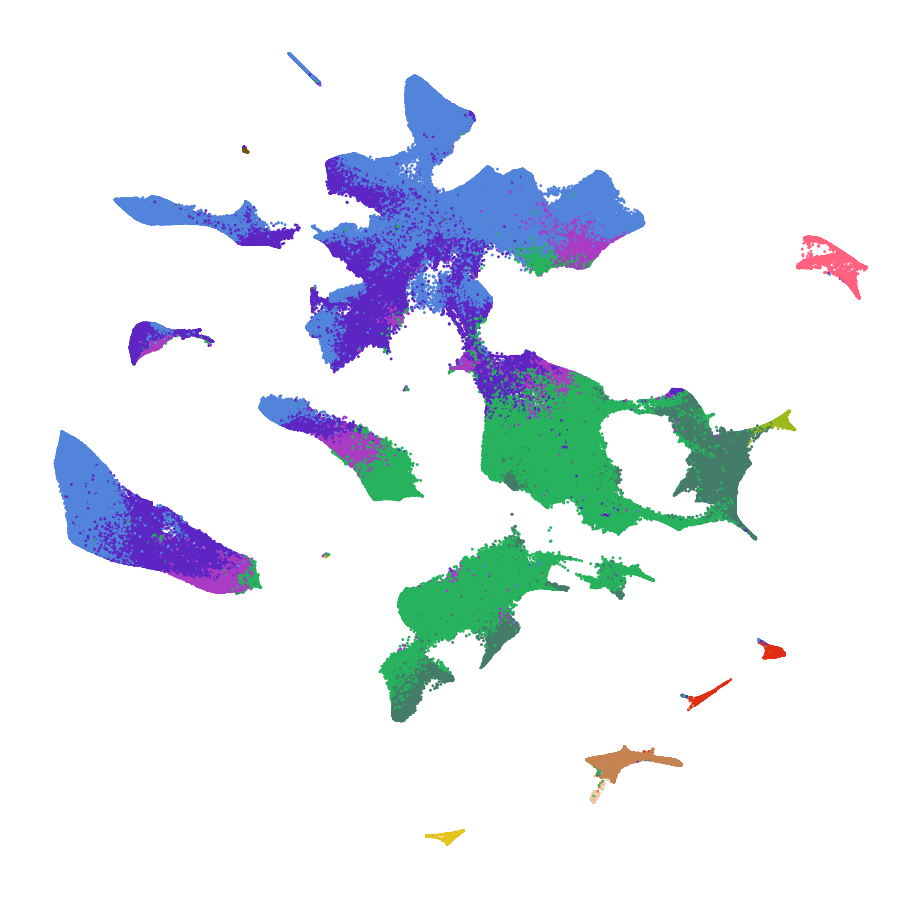

In [5]:
# Fig 1A
plt.figure(figsize=(8, 8))
cgplot.scatterc(xy, c=classes, colors="classes", s=2, legend=None)
plt.axis("off")
None

(-23.698065090179444,
 27.966030406951905,
 -31.899764442443846,
 26.0392183303833)

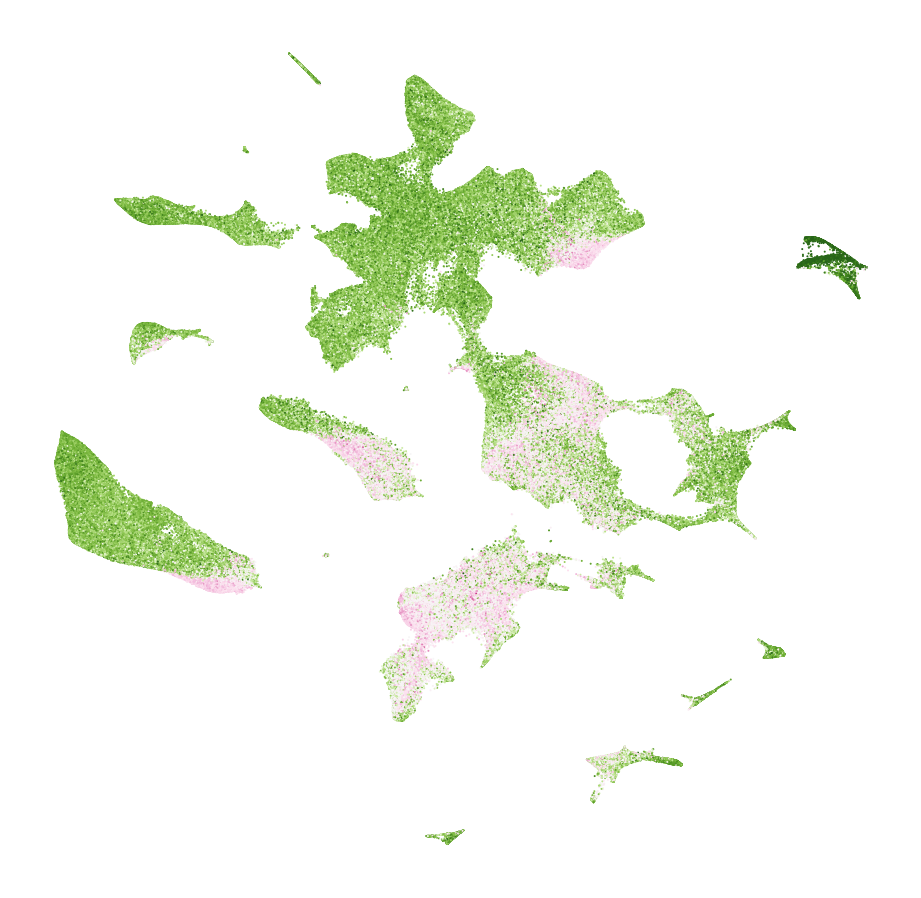

In [13]:
# Cell cycle
from matplotlib.colors import TwoSlopeNorm
ws = db.builds.sten.humandev20220523.PoolClean
xy = ws.Embedding[:]
plt.figure(figsize=(8, 8))
cgplot.scattern(xy, c=ws.CellCycleFraction[:], norm=TwoSlopeNorm(vcenter=0.004), cmap="PiYG_r", s=1)
plt.axis("off")
#plt.colorbar()

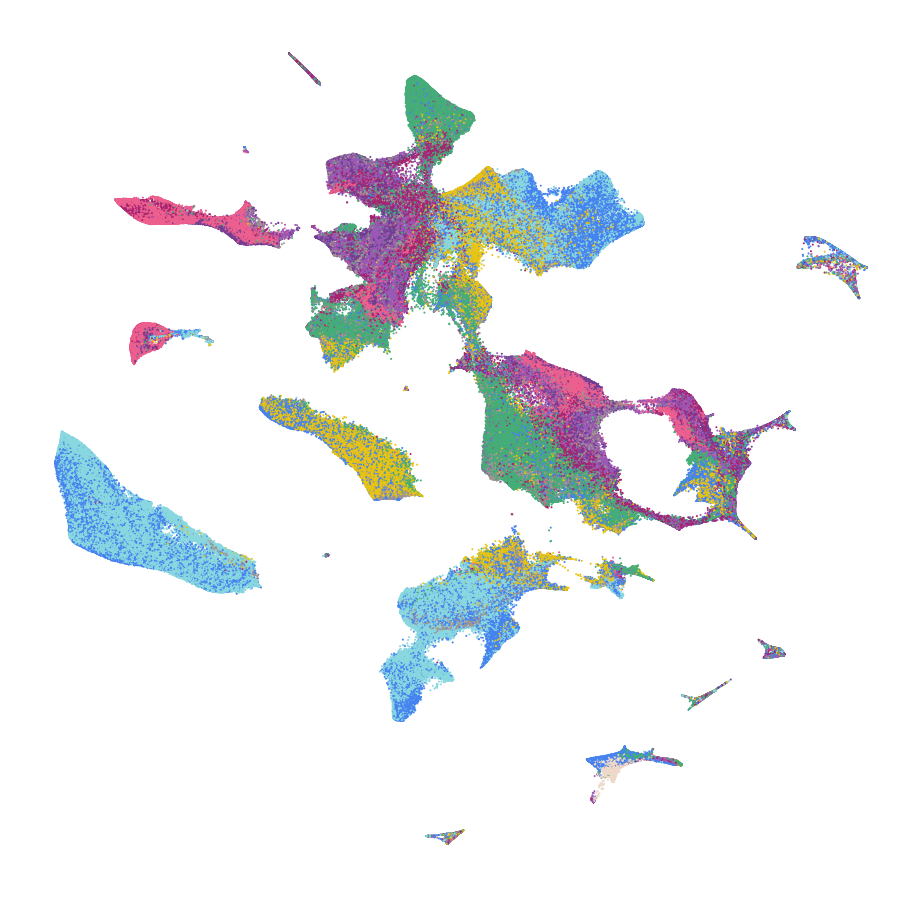

In [12]:
# Regions
plt.figure(figsize=(8, 8))
cgplot.scatterc(xy, c=regions, colors="regions", s=1, legend=None)
plt.axis("off")
None

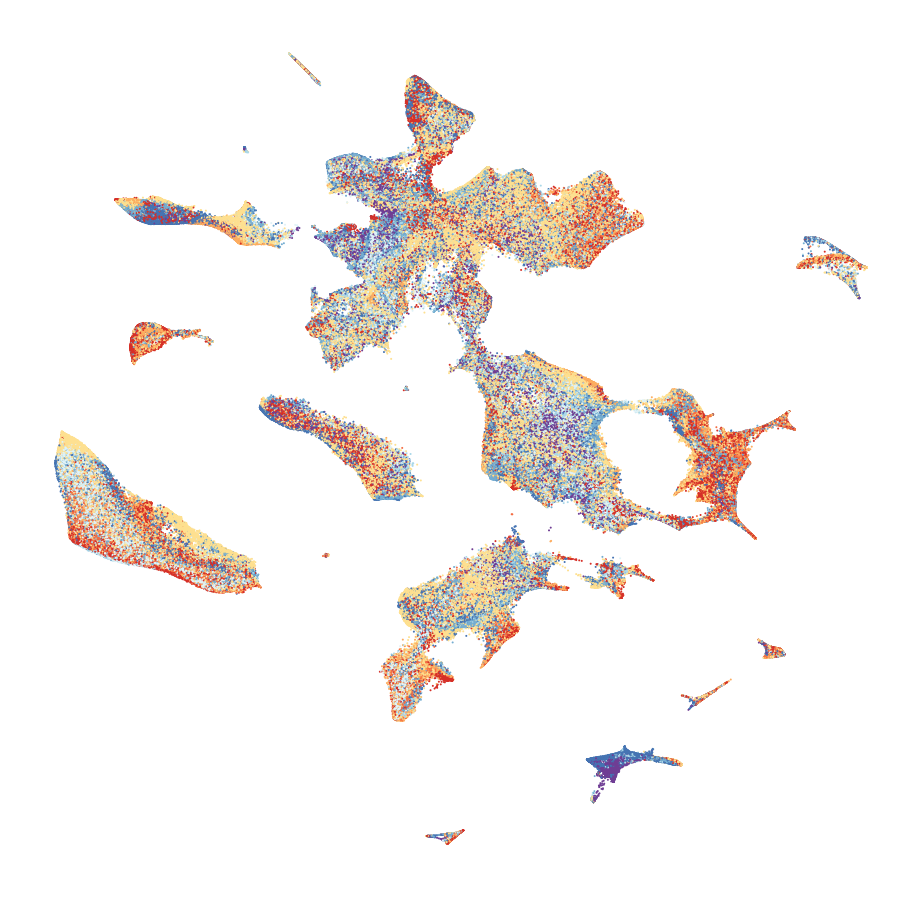

In [11]:
# Age
plt.figure(figsize=(8, 8))
cgplot.scatterc(xy, c=ages, colors="age", s=1, legend=None, vmin=5, vmax=14)
plt.axis("off")
None

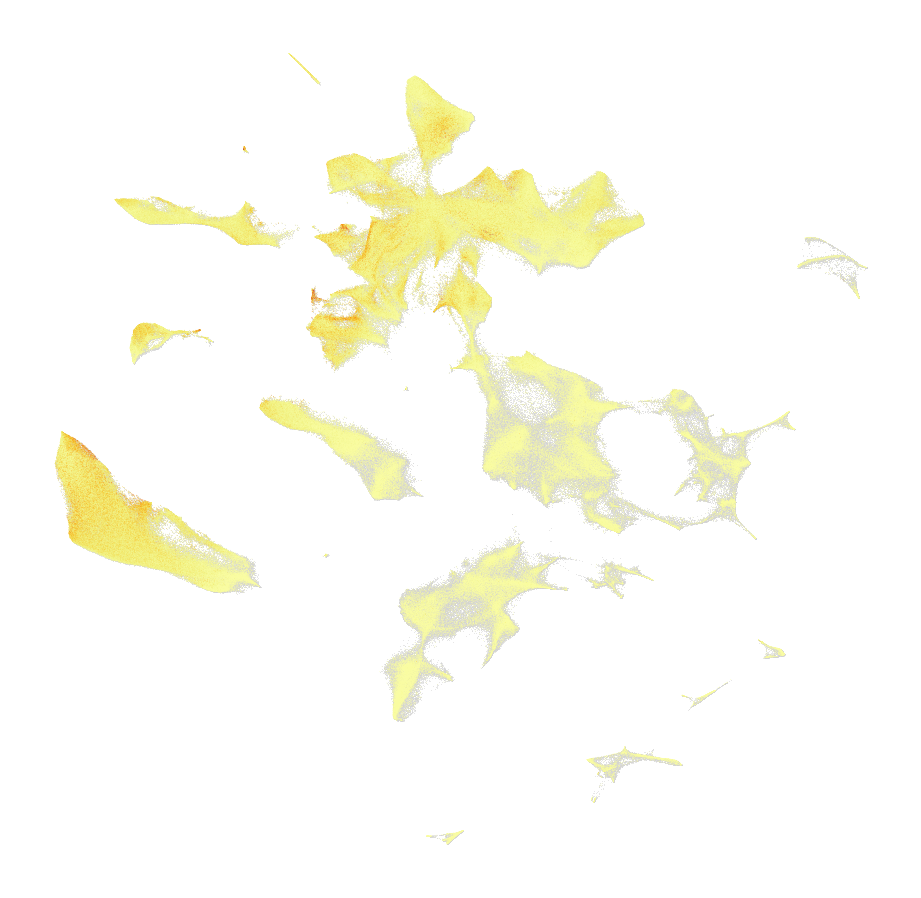

In [37]:
# Expression of markers (change as needed)
gene = "STMN2"
plt.figure(figsize=(8, 8))
cgplot.scattern(xy, c=ws.Expression[:, ws.Gene == gene].flatten(), s=0.1, bgval=0)
plt.axis("off")
None

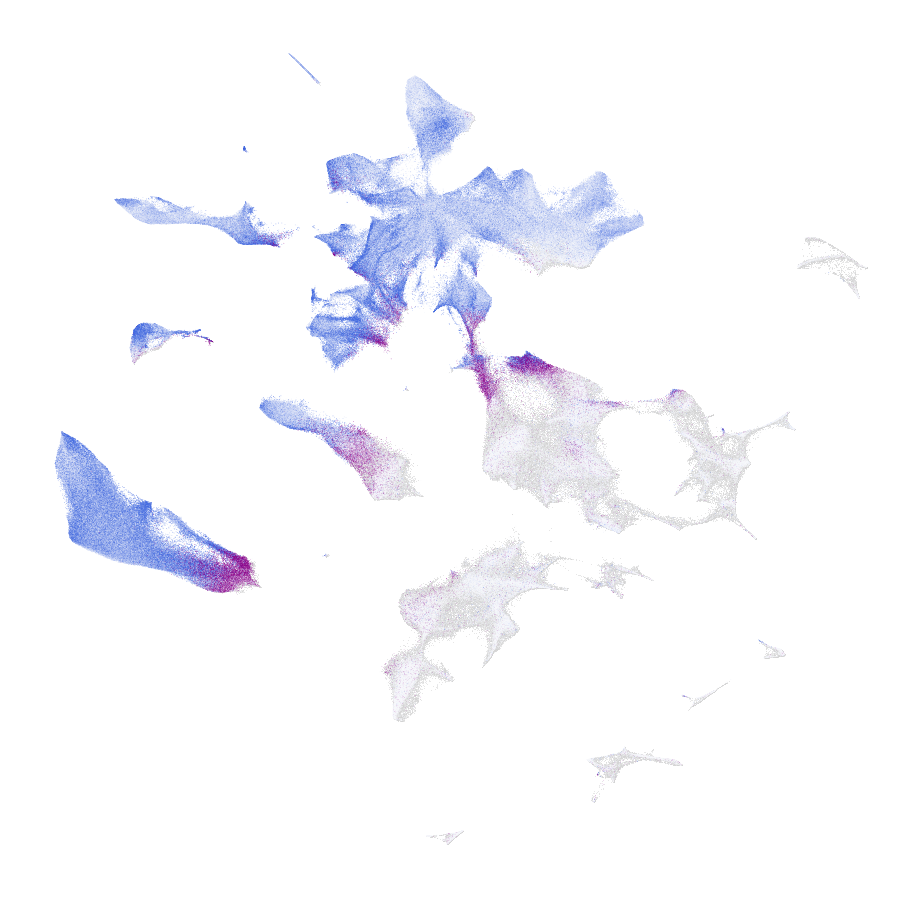

In [38]:
# Multiplexed plot for the radial zones fig S3
genes = ["NHLH1", "STMN2", "SOX2"]
plt.figure(figsize=(8, 8))
cgplot.scatterm(xy, c=[ws.Expression[:, ws.Gene == gene].flatten() for gene in genes], cmaps=["darkmagenta", "royalblue", "limegreen"], s=0.1, bgval=0, max_percentile=95, labels=genes, legend=None)
plt.axis("off")
None

In [7]:

def sparkline(ax, x, ymax, color, plot_label, labels, subtrees):
    n_clusters = labels.max() + 1
    if ymax is None:
        ymax = np.max(x)
    ax.bar(np.arange(n_clusters) + 0.5, x, color=color, width=1, lw=0)
    ax.set_xlim(0, n_clusters + 1)
    ax.set_ylim(0, ymax)
    ax.axis("off")
    ax.text(0, 0, plot_label, va="bottom", ha="right", transform=ax.transAxes)
    for ix in range(subtrees.max() + 1):
        ax.vlines(labels[subtrees == ix].max() + 1, 0, ymax, linestyles="--", lw=1, color="grey")


def plot_regions(ax, regions, region_colors, labels, subtrees):
    classes = np.array(list(region_colors.keys()))
    n_classes = len(classes)
    le = OrdinalEncoder(categories=[classes])
    le.fit(regions.reshape(-1, 1))
    n_clusters = labels.max() + 1
    distro = np.zeros((n_classes, n_clusters))
    for label in np.arange(n_clusters):
        subset = le.transform(regions[labels == label].reshape(-1, 1)).flatten().astype("int32")
        d = aggregate(subset, subset, func="count", size=n_classes)
        distro[:, label] = d

    opacity = distro / distro.sum(axis=0)
    color = np.zeros((n_classes, n_clusters, 4))
    color[:, :, 3] = opacity
    for ix, cls in enumerate(classes):
        color[ix, :, :3] = to_rgb(region_colors[cls])
    ax.imshow(color, cmap=plt.cm.Reds, aspect='auto', interpolation="nearest", origin="upper", extent=(0, n_clusters, n_classes, 0))
    ax.set_yticks(np.arange(n_classes) + 0.5)
    ax.set_yticklabels(classes, fontsize=7)
    ax.set_xticks([])
    ax.hlines(n_classes, 0, n_clusters, lw=1, linestyles="--", color="grey")
    for ix in range(subtrees.max() + 1):
        ax.vlines(labels[subtrees == ix].max() + 1, 0, n_classes, linestyles="--", lw=1, color="grey")
    ax.set_ylim(n_classes, 0)
    ax.set_xlim(0, n_clusters)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)


def plot_ages(ax, ages, labels, subtrees):
    le = LabelEncoder()
    le.fit(ages)
    n_clusters = labels.max() + 1
    n_classes = len(le.classes_)
    distro = np.zeros((n_classes, n_clusters))
    for label in np.arange(n_clusters):
        subset = le.transform(ages[labels == label])
        d = aggregate(subset, subset, func="count", size=n_classes)
        distro[:, label] = d

    distro = (distro.T / distro.sum(axis=1)).T
    distro = distro / distro.sum(axis=0)
    classes = le.classes_

    ax.imshow(distro, cmap=plt.cm.Reds, aspect='auto', interpolation="nearest", origin="lower", extent=(0, n_clusters, 0, n_classes))
    ax.set_yticks(np.arange(len(classes)) + 0.5)
    ax.set_yticklabels(classes, fontsize=7)
    ax.hlines(np.arange(5, len(classes), 5), 0, n_clusters, lw=1, linestyles="--", color="grey")
    for ix in range(subtrees.max() + 1):
        ax.vlines(labels[subtrees == ix].max() + 1, 0, len(classes), linestyles="--", lw=1, color="grey")
    ax.set_ylim(len(classes), 0)
    ax.set_xlim(0, n_clusters)
    ax.set_ylabel("Age (p.c.w.)")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)


def plot_genes(ax, mgenes, mean_x, genes, labels, subtrees):
    # Add the markers
    m = []
    m_names = []
    for gene in mgenes:
        gene_ix = np.where(genes == gene)[0][0]
        m.append(mean_x[:, gene_ix])
        m_names.append(f"{gene}")
    n_genes = len(m_names)
    n_clusters = labels.max() + 1

    # Normalize
    x = np.array(m)
    x_norm = cg.div0(x.T, np.percentile(x, 99.9, axis=1)).T
    bg = np.zeros_like(x_norm) + 0.9
    x_norm = np.ma.masked_where(x == 0, x_norm)


    ax.imshow(bg, vmin=0, vmax=1, cmap=plt.cm.gray, aspect="auto", extent=(0, n_clusters, n_genes, 0), alpha=1, interpolation="nearest", resample=False)
    ax.imshow(x_norm, cmap="inferno_r", vmax=1, interpolation="nearest", aspect="auto", alpha=1, extent=(0, n_clusters, n_genes, 0), resample=False)

    #ax.imshow(np.log10(x_norm + 0.001), vmin=-1, vmax=2, cmap="RdGy_r", interpolation="none", aspect="auto", extent=(0, n_clusters, n_genes, 0))
    ax.set_yticks(np.arange(len(m_names)) + 0.5)
    ax.set_yticklabels(m_names, fontsize=7)
    for ix in range(subtrees.max() + 1):
        ax.vlines(labels[subtrees == ix].max() + 1, 0, n_genes, linestyles="--", lw=1, color="grey")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

def plot_dendrogram(ax, n_clusters, linkage, labels, subtrees):
    lc = cgplot.dendrogram(linkage, leaf_positions=np.arange(n_clusters) + 0.5)
    lc.set_linewidth(0.5)
    lc.set_color("black")
    ax.add_collection(lc)
    ax.set_xlim(0, n_clusters)
    ax.set_ylim(0, linkage[:, 2].max())
    ax.axis("off")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

def plot_classes(ax, classes, subtrees):
    colors = np.array([hex2color(x) for x in cgplot.Colorizer("classes").fit_transform(classes)])
    ax.imshow(colors[None, :],aspect="auto", extent=(0, len(classes), 1, 0), interpolation="nearest")

    ax.axis("off")
    ax.text(0, 0, "Class", va="bottom", ha="right", transform=ax.transAxes)

def plot_agestrip(ax, ages, subtrees):
    colors = np.array([hex2color(x) for x in cgplot.Colorizer("ages").fit_transform(classes)])
    ax.imshow(colors[None, :],aspect="auto", extent=(0, len(classes), 1, 0), interpolation="nearest")
    for ix in range(subtrees.max() + 1):
        ax.vlines(labels[subtrees == ix].max() + 1, 0, 1, linestyles="--", lw=1, color="grey")

    ax.axis("off")
    ax.text(0, 0, "Class", va="bottom", ha="right", transform=ax.transAxes)


In [8]:
# Cut the tree into subtrees with about ten clusters each
cluster_subtrees = cut_tree(linkage, n_clusters=30).flatten().astype("int")
# Map this onto the individual cells
subtrees = np.zeros(ws.cells.length, dtype="uint32")
for j in range(n_clusters):
    subtrees[labels == j] = cluster_subtrees[j]

    

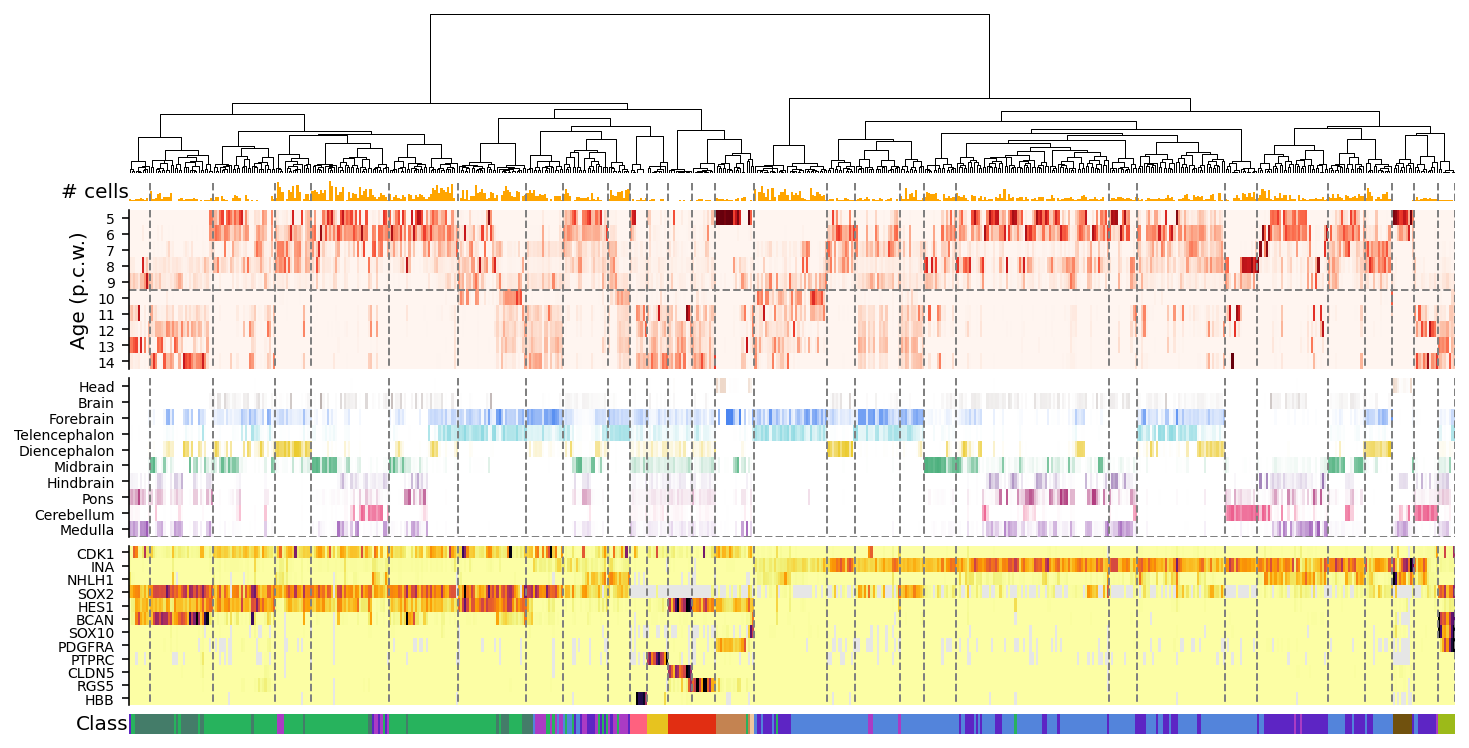

In [9]:
# Fig. 1C
fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, gridspec_kw={"height_ratios": (2, 0.25, 2, 2, 2, 0.25)}, figsize=(10, 5))
plot_dendrogram(axes[0], n_clusters, linkage, labels, subtrees)
sparkline(axes[1], n_cells, None, "orange", "# cells", labels, subtrees)
plot_ages(axes[2], week, labels, subtrees)
plot_regions(axes[3], regions, cgplot.Colorizer("regions").dict(), labels, subtrees)
plot_genes(axes[4], ["CDK1", "INA", "NHLH1", "SOX2", "HES1", "BCAN", "SOX10", "PDGFRA", "PTPRC", "CLDN5", "RGS5", "HBB"], mean_x, genes, labels, subtrees)
plot_classes(axes[5], classes_by_cluster, subtrees)

fig.tight_layout(pad=0, h_pad=0, w_pad=0)

#plt.savefig("Humandev_Fig1.pdf", dpi=300)

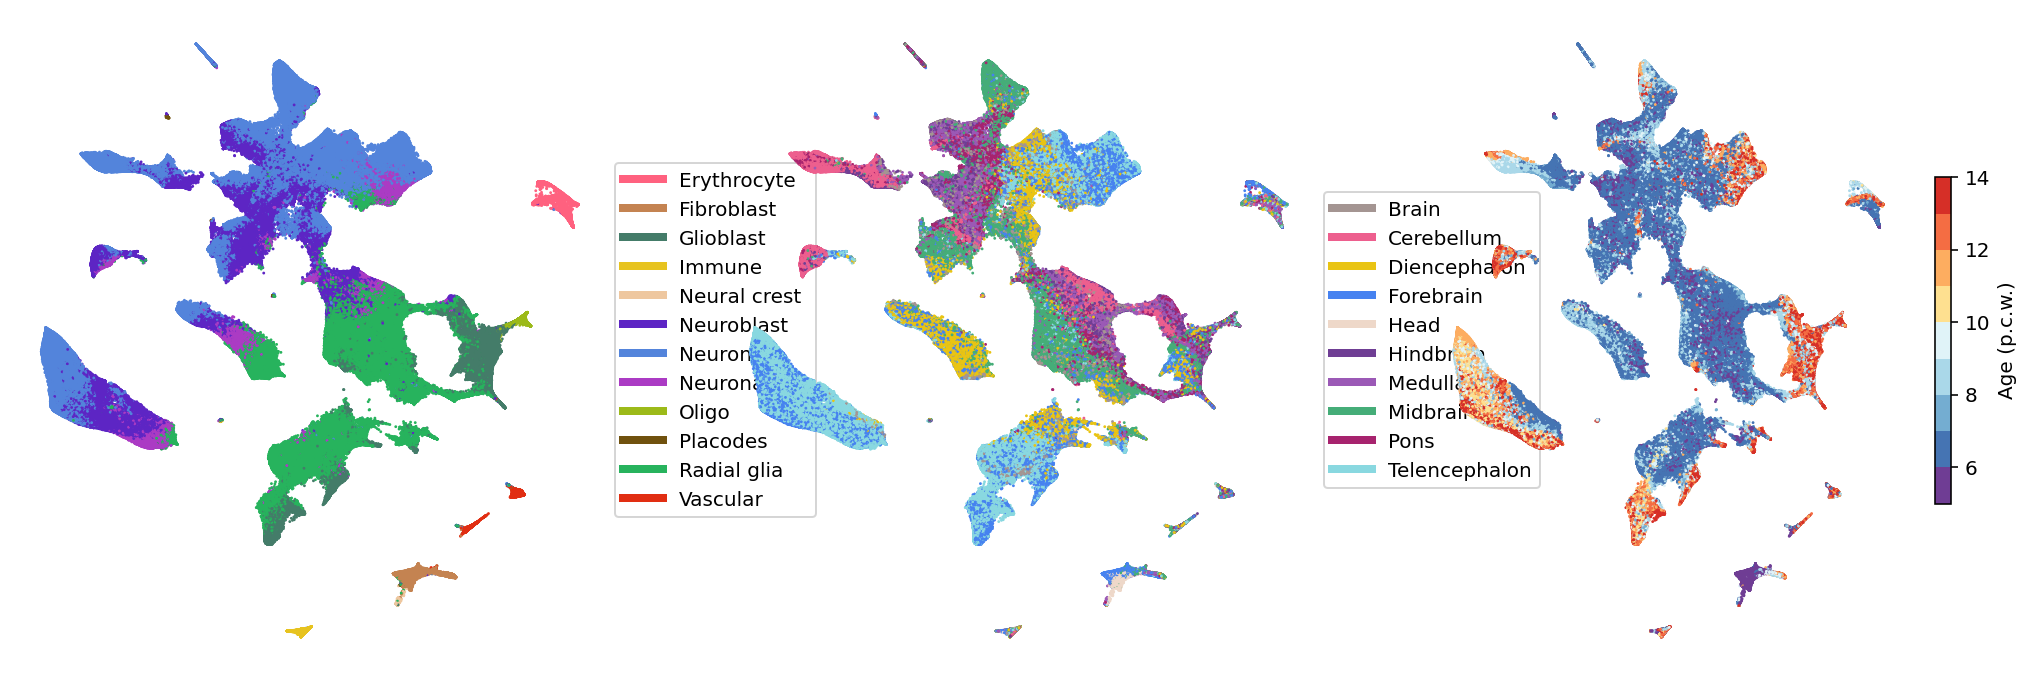

In [10]:
step = 1
plt.figure(figsize=(18,6))
plt.subplot(131)
cgplot.scatterc(xy, c=classes[::step], colors="classes", s=2)
plt.axis("off")
plt.subplot(132)
cgplot.scatterc(xy, c=regions[::step], colors="regions", s=2)
plt.axis("off")
plt.subplot(133)
cgplot.scattern(xy, c=ages[::step], cmap="age", vmin=5, vmax=14, s=2)
plt.colorbar(label="Age (p.c.w.)", shrink=0.5)
plt.axis("off")

None

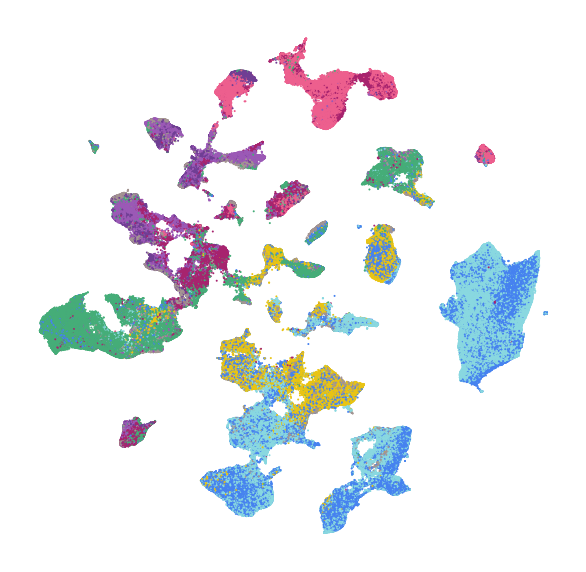

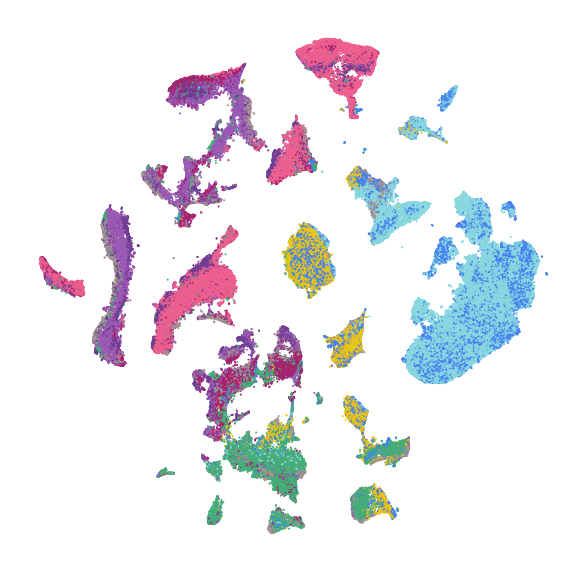

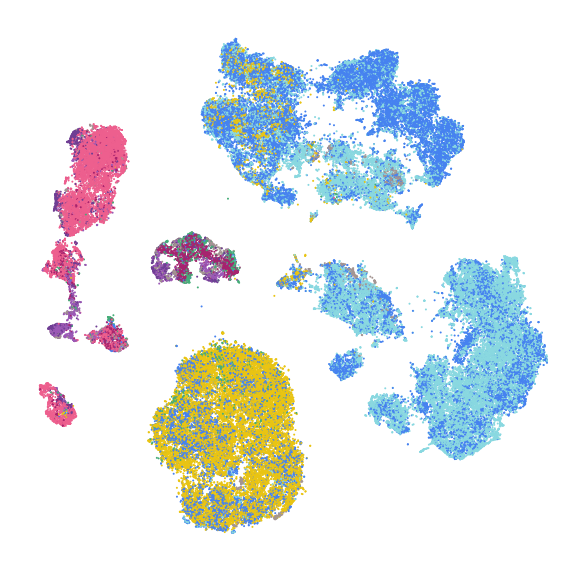

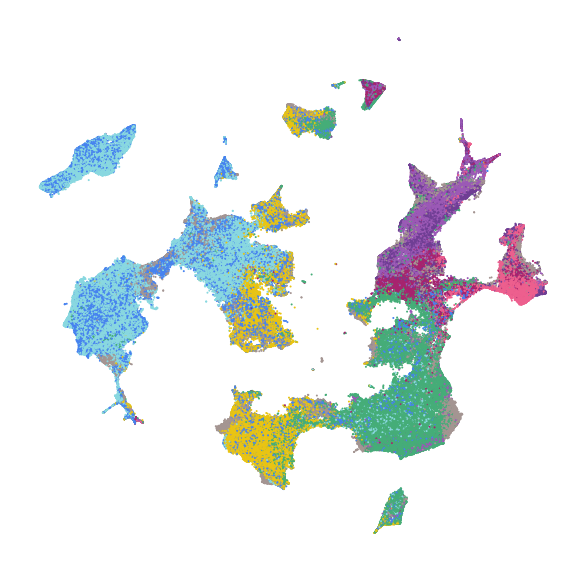

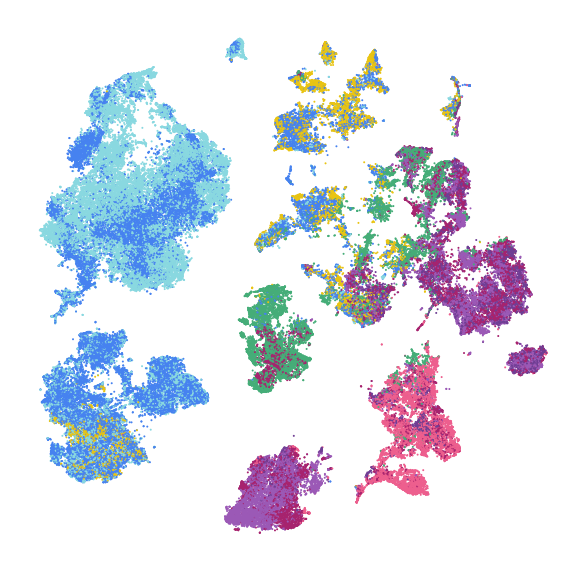

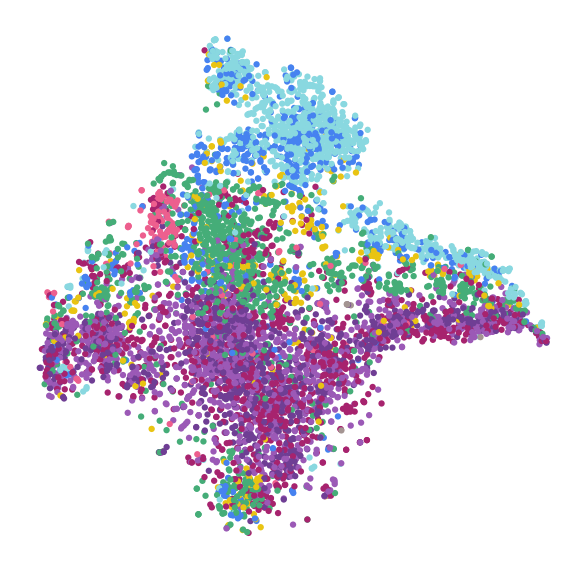

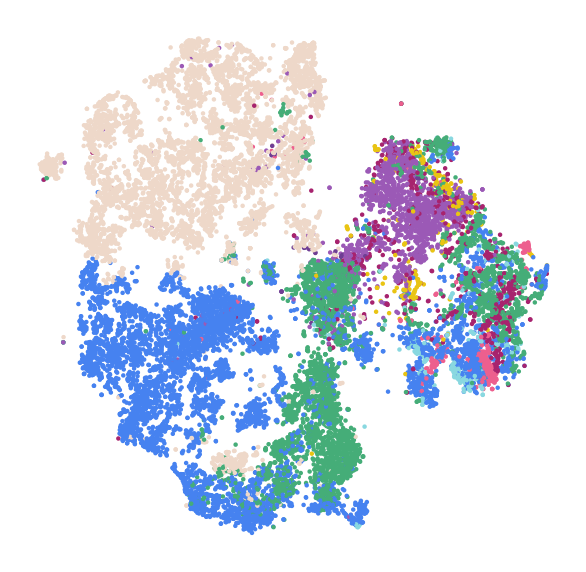

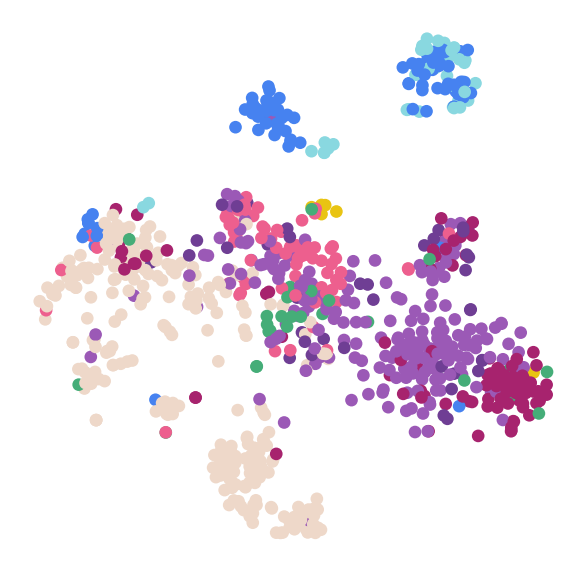

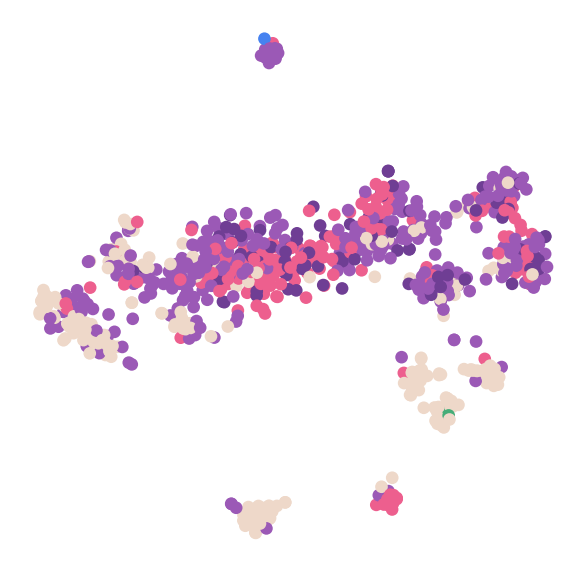

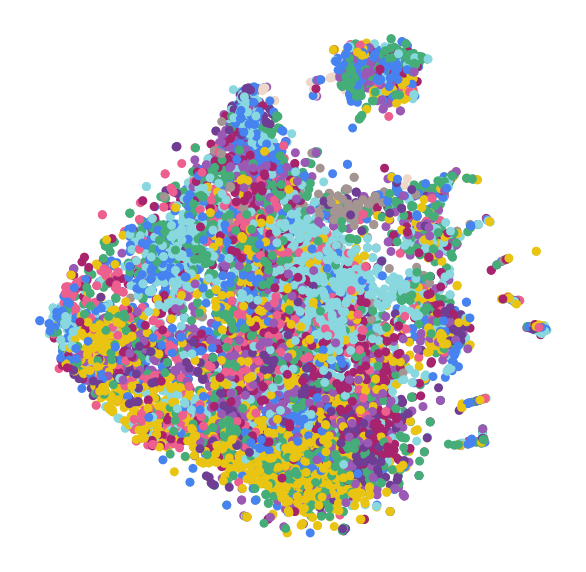

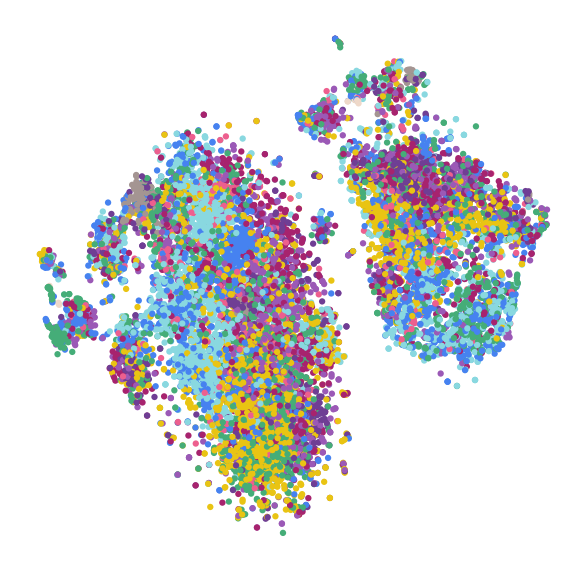

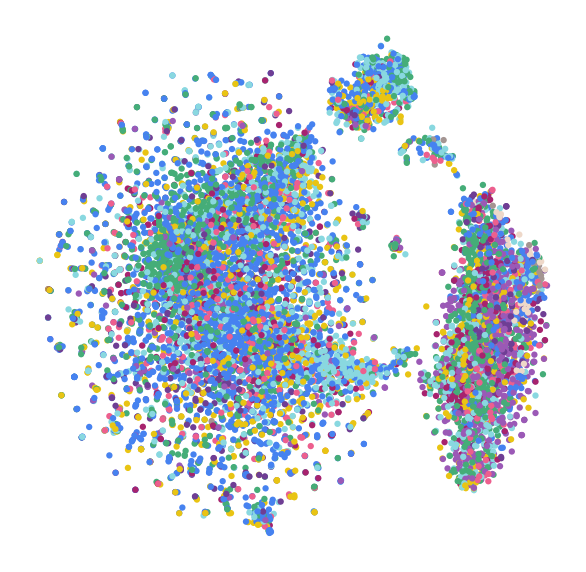

In [15]:
# Fig. 1D
sizes = [1, 1, 1, 1, 1, 10, 5, 40, 40, 20, 10, 10, 20]
for i, cls in enumerate(['Neuron', 'Neuroblast', 'NeuronalIPC', 'RadialGlia', 'Glioblast', 'Oligo', 
                    'Fibroblast', 'NeuralCrest', 'Placodes', 'Immune', 'Vascular', 'Erythrocyte']):
    plt.figure(figsize=(5, 5))
    ws = db.builds.sten.humandev20220523["Class" + cls]
    xy = ws.Embedding[:]
    regions = ws.Region[:]
    cgplot.scatterc(xy, c=regions, colors="regions", legend=None, s=sizes[i])
    plt.axis("off")

In [ ]:
# Compute UMAPs for all the classes
from umap import UMAP
for i, cls in enumerate(['Neuron', 'Neuroblast', 'NeuronalIPC', 'RadialGlia', 'Glioblast', 'Oligo', 
                    'Fibroblast', 'NeuralCrest', 'Placodes', 'Immune', 'Vascular', 'Erythrocyte']):
    print(cls)
    ws = db.builds.sten.humandev20220523["Class" + cls]
    umap = UMAP(n_neighbors=50, min_dist=0.5, init=ws.Embedding[:]).fit_transform(ws.Factors[:])
    ws.UMAP = shoji.Tensor(dtype="float32", dims=("cells", 2), inits=umap.astype("float32"))

Neuron
Neuroblast


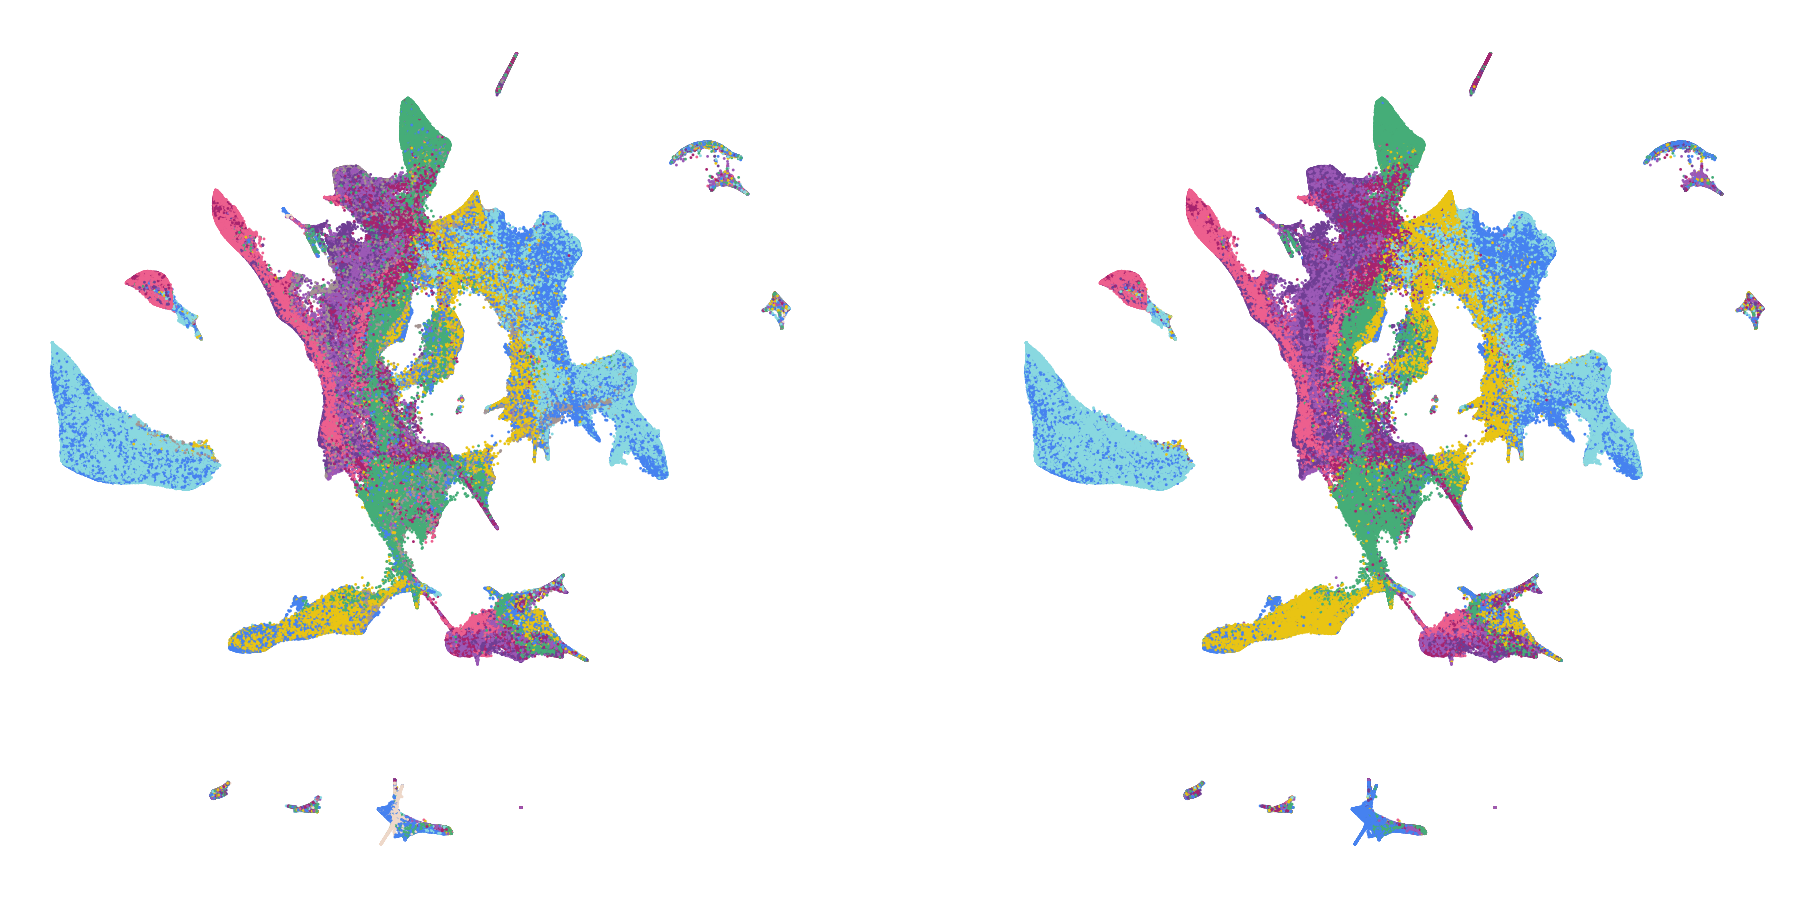

In [32]:
predicted = np.load("/proj/human_development/manuscript/data/predicted_regions/predicted_regions.npy", allow_pickle=True)
ws = db.builds.sten.humandev20220523.BrainBasicPool
xy = ws.Embedding[:]
plt.figure(figsize=(16, 8))
plt.subplot(121)
cgplot.scatterc(xy, c=ws.Region[:], colors="regions", s=2, legend=None)
plt.axis("off")

plt.subplot(122)
cgplot.scatterc(xy, c=predicted, colors="regions", s=2, legend=None)
plt.axis("off")
None

In [126]:
# Histogram of cell cycle score for whole dataset
ws = db.builds.sten.humandev20220523.PoolClean
cc = ws.CellCycleFraction[:]
labels = ws.Clusters[:]
classes = ws.CellClass[:]

In [118]:
n_clusters = labels.max() + 1
hists = np.zeros((n_clusters, 40))
for i in range(n_clusters):
    hists[i, :] = np.histogram(cc[labels == i], bins=40, range=(0, 0.05), density=True)[0]

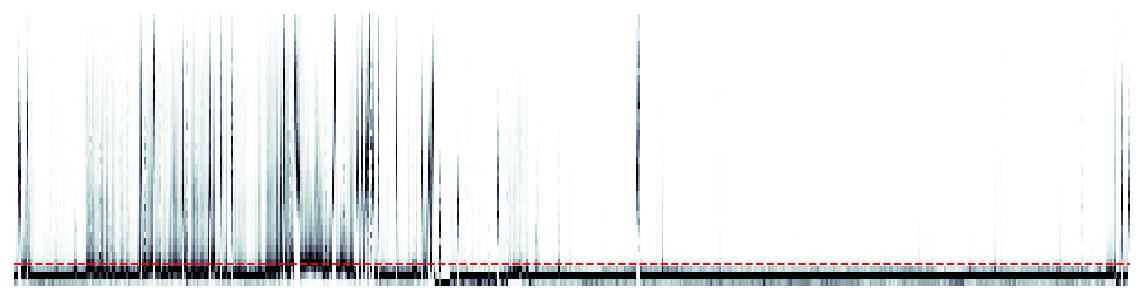

In [125]:
plt.figure(figsize=(10, 2.5))
plt.imshow(hists.T / hists.max(axis=1), cmap="bone_r", origin="lower", aspect="auto", interpolation="nearest", extent=(0, n_clusters, 0, 0.05))
plt.yticks(np.arange(0, 0.05, 0.002), np.arange(0, 0.05, 0.002))
plt.hlines(0.004, 0, n_clusters, linestyles="--", lw=1, color="red")
plt.xlim(0, n_clusters)
plt.ylim(0, 0.05)
plt.axis("off")
None

In [142]:
# Fraction cycling per class
class_names = np.array(['Neuron', 'Neuroblast', 'Neuronal IPC', 'Radial glia', 'Glioblast', 'Oligo', 
                    'Fibroblast', 'Neural crest', 'Placodes', 'Immune', 'Vascular', 'Erythrocyte'])
f_cc = []
for i, cls in enumerate(class_names):
    xcc = cc[classes == cls]
    f_cc.append((xcc > 0.004).sum() / len(xcc))

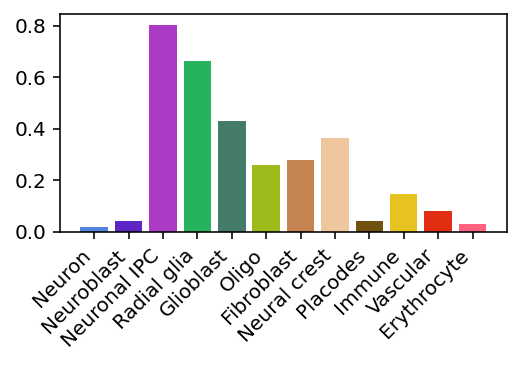

In [151]:
plt.figure(figsize=(4,2))
plt.bar(range(12), f_cc, color=cgplot.Colorizer("classes").fit_transform(class_names))
plt.xticks(range(12), class_names, rotation=45, va="top", ha="right")
#plt.axis("off")
None